In [1]:
from data_functions import *

# Create NetCDF files with the forcing data from the mCDR model and the results of the pCO2 sensitivity calculation

In [2]:
# Define the regions of interest
regions = {"ACC": [-3, 3, -50, -45], 
           "EBC": [130, 135, 30, 35], 
           "NAS": [16, 23, 56, 62], 
           "EU": [165, 170, -2, 2], 
           "WBC": [-148, -144, 31, 38]
           } 

## 1) Save forcing data monthly mean from mCDR vertical model for each interested region

In [11]:
# Define the name to the NetCDF file containing forcing data
fname = "model_forcing_data_daily"

# Define the file name to save the monthly mean forcing data
fname_save = "monthly_mean_forcing_data_RapidmCDR"

# Define the variables to save
vars = ["k_diff", "k_surf", "siarea", "area", "alk_forcing", "sst", "salt"]

In [12]:
# Loop through each region
for region_name in regions.keys():
    filename = f"{region_name}_{fname_save}.nc"

    # Check if the file already exists → remove it to overwrite cleanly
    if os.path.exists(filename):
        print(f"File {filename} already exists. Overwriting...")
        os.remove(filename)

    # Load the forcing data from the mCDR model
    ds = xr.open_dataset(
        f"C:\\Users\\ocean\\PycharmProjects\\Master MIX\\StageM2\\rapid_mcdr_paper\\data\\{region_name}\\{fname}.nc")

    # Verify the time variable format (in datetime64)
    ds["time"] = xr.decode_cf(ds).time

    # Create a new variable year_month to group the data by month
    ds["year_month"] = ds["time"].dt.strftime("%Y-%m")

    # Regroup the data by year_month and compute the mean values
    ds_monthly_mean = ds[vars].groupby(ds["year_month"]).mean(dim="time")

    # Save the monthly mean values of forcing data to a new NetCDF file for each region
    ds_monthly_mean.to_netcdf(filename)

    print(f"File {filename} created successfully!")

File ACC_monthly_mean_forcing_data_RapidmCDR.nc already exists. Overwriting...
File ACC_monthly_mean_forcing_data_RapidmCDR.nc created successfully!
File EBC_monthly_mean_forcing_data_RapidmCDR.nc already exists. Overwriting...
File EBC_monthly_mean_forcing_data_RapidmCDR.nc created successfully!
File NAS_monthly_mean_forcing_data_RapidmCDR.nc already exists. Overwriting...
File NAS_monthly_mean_forcing_data_RapidmCDR.nc created successfully!
File EU_monthly_mean_forcing_data_RapidmCDR.nc already exists. Overwriting...
File EU_monthly_mean_forcing_data_RapidmCDR.nc created successfully!
File WBC_monthly_mean_forcing_data_RapidmCDR.nc already exists. Overwriting...
File WBC_monthly_mean_forcing_data_RapidmCDR.nc created successfully!


## 2) a. Calculate the pCO2 sensitivity from ECCO-Darwin and mCDR models output data for each interested region

In [18]:
# Define the date used for pCO2 sensitivity calculation
dtime = "1995-01"

In [19]:
# Load the DIC and ALK data for the specified date
DIC = xr.open_dataset(f"DIC_{dtime}_0.nc")
ALK = xr.open_dataset(f"ALK_{dtime}_0.nc")

# Loop through each defined region
for region_name in regions.keys():
    # Define the output filename for the sensitivity data at each region
    filename = f"{region_name}_sensitivity_pco2_{dtime}.nc"
    
    # Check if the file already exists
    if os.path.exists(filename):
        print(f"File {filename} already exists.")
        continue
        
    # Load the previously saved NetCDF data containing monthly means
    ds = xr.open_dataset(f"{region_name}_{fname_save}.nc")
    
    # Select salt and sst values at the specified date and region
    salt = ds["salt"].sel(year_month=dtime).values
    sst = ds["sst"].sel(year_month=dtime).values
    
    # Crop DIC and ALK data for the region
    dic_crop, lat_indices, lon_indices = crop_var(DIC, "DIC", regions[region_name])
    alk_crop, _, _ = crop_var(ALK, "ALK", regions[region_name])
    
    # Compute the pCO2 sensitivity to DIC and ALK
    dpco2_ov_ddic, dpco2_ov_dalk = compute_dpco2_sensitivity(dic_crop, alk_crop, salt, sst)
        
    # Dimensions from full domain
    lat = DIC["Latitude"].values
    lon = DIC["Longitude"].values
    
    # Create empty (NaN-filled) arrays with full shape
    shape = (1, lat.shape[0], lon.shape[1])  # 1 for the year_month dim
    dpco2_ddic = np.full(shape, np.nan)
    dpco2_dalk = np.full(shape, np.nan)
    
    # Insert cropped sensitivity values into the correct positions
    for i, lat_idx in enumerate(lat_indices):
        for j, lon_idx in enumerate(lon_indices):
            dpco2_ddic[0, lat_idx, lon_idx] = dpco2_ov_ddic[i, j]
            dpco2_dalk[0, lat_idx, lon_idx] = dpco2_ov_dalk[i, j]
    
    # Create new DataArray for dpCO2/dDIC with coordinates and attributes
    dpco2_ddic_data = xr.DataArray(
        dpco2_ddic,
        dims=("year_month", "y", "x"),
        coords={"year_month": [dtime]},
        attrs={"long_name": "d pCO2/d DIC", "units": "atm / (mol C/kg)"}
    )
    
    # Create new DataArray for dpCO2/dALK with coordinates and attributes
    dpco2_dalk_data = xr.DataArray(
        dpco2_dalk,
        dims=("year_month", "y", "x"),
        coords={"year_month": [dtime]},
        attrs={"long_name": "d pCO2/d ALK", "units": "atm / (mol ALK/kg)"}
    )

    # Create a new dataset for storing pCO2 sensitivity results
    ds_sensitivity = xr.Dataset({
        "dpco2_ov_ddic": dpco2_ddic_data,
        "dpco2_ov_dalk": dpco2_dalk_data,
        "Latitude": (("y", "x"), lat),
        "Longitude": (("y", "x"), lon)
    })

    # Save the pCO2 sensitivity dataset to a new NetCDF file for each region
    ds_sensitivity.to_netcdf(filename)

    print(f"File {filename} created successfully!")

File ACC_sensitivity_pco2_1995-01.nc created successfully!


C:\Users\ocean\PycharmProjects\Master MIX\venv\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\ocean\PycharmProjects\Master MIX\venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:77: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
C:\Users\ocean\PycharmProjects\Master MIX\venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:52: RuntimeWarning: invalid value encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
C:\Users\ocean\PycharmProjects\Master MIX\venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:34: RuntimeWarning: invalid value encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: x * g))


Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
File EBC_sensitivity_pco2_1995-01.nc created successfully!
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.


C:\Users\ocean\PycharmProjects\Master MIX\venv\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\ocean\PycharmProjects\Master MIX\venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:77: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)


Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.


C:\Users\ocean\PycharmProjects\Master MIX\venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:52: RuntimeWarning: invalid value encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
C:\Users\ocean\PycharmProjects\Master MIX\venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:34: RuntimeWarning: invalid value encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: x * g))


Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
File NAS_sensitivity_pco2_1995-01.nc created successfully!
File EU_sensitivity_pco2_1995-01.nc created successfully!
File WBC_sensitivity_pco2_1995-01.nc created successfully!


## 2) b. Another method : Calculate the pCO2 sensitivity from ECCO-Darwin output data for the global ocean (requires much more computing time and storage space)

In [28]:
# Define the output filename for the global sensitivity data 
filename = f"sensitivity_pco2_{dtime}.nc"

# Check if the file already exists
if os.path.exists(filename):
    print(f"File {filename} already exists.")
else:
    # Load the global DIC, ALK, SALT and SST data for the specified date
    data = xr.open_dataset(f"DIC_{dtime}_0.nc")
    DIC = data["DIC"].values
    ALK = xr.open_dataset(f"ALK_{dtime}_0.nc")["ALK"].values
    SALT = xr.open_dataset(f"SALT_{dtime}_0.nc")["SALT"].values
    SST = xr.open_dataset(f"SST_{dtime}_0.nc")["SST"].values
    
    # Load the Latitude et Longitude from the global data
    latitude = data["Latitude"].values
    longitude = data["Longitude"].values
    
    # Compute the pCO2 sensitivity to global DIC and ALK fields
    dpco2_ov_ddic, dpco2_ov_dalk = compute_dpco2_sensitivity(DIC, ALK, SALT, SST)
        
    # Create new DataArray for dpCO2/dDIC with coordinates and attributes
    dpco2_ddic_data = xr.DataArray(
        dpco2_ov_ddic,
        dims=("year_month", "y", "x"),
        coords={"year_month": [dtime]},
        attrs={"long_name": "d pCO2/d DIC", "units": "atm / (mol C/kg)"}
    )
    
    # Create new DataArray for dpCO2/dALK with coordinates and attributes
    dpco2_dalk_data = xr.DataArray(
        dpco2_ov_dalk,
        dims=("year_month", "y", "x"),
        coords={"year_month": [dtime]},
        attrs={"long_name": "d pCO2/d ALK", "units": "atm / (mol ALK/kg)"}
    )

    # Create a new dataset for storing pCO2 sensitivity results
    ds_sensitivity = xr.Dataset({
        "dpco2_ov_ddic": dpco2_ddic_data,
        "dpco2_ov_dalk": dpco2_dalk_data,
        "Latitude": (("y", "x"), latitude),
        "Longitude": (("y", "x"), longitude)
    })
    
    # Save the pCO2 sensitivity dataset to a new NetCDF file for the entire globe 
    ds_sensitivity.to_netcdf(filename)
    
    print(f"File {filename} created successfully!")

File sensitivity_pco2_1995-01.nc already exists.


### Visualize the pCO2 sensitivity global results

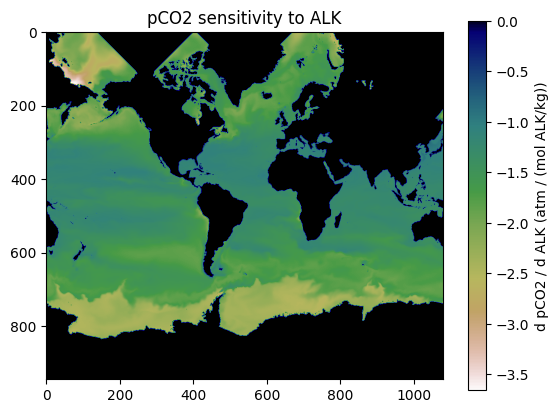

In [72]:
ds = xr.open_dataset("sensitivity_pco2_1995-01.nc")

plt.figure()
plt.imshow(ds["dpco2_ov_dalk"][0, ::-1, :], cmap="gist_earth_r")
plt.colorbar(label="d pCO2 / d ALK (atm / (mol ALK/kg))")
plt.title("pCO2 sensitivity to ALK")
plt.show()

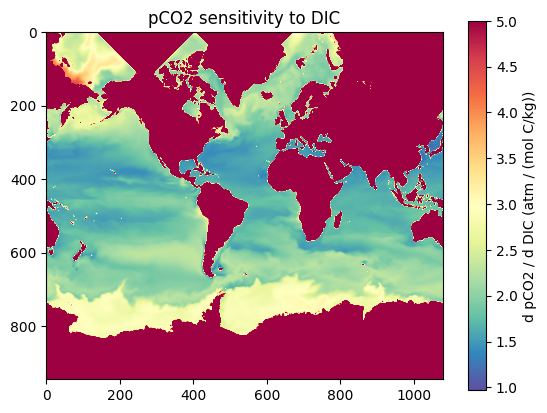

In [73]:
plt.figure()
plt.imshow(ds["dpco2_ov_ddic"][0, ::-1, :], cmap="Spectral_r", vmax=5)
plt.colorbar(label="d pCO2 / d DIC (atm / (mol C/kg))")
plt.title("pCO2 sensitivity to DIC")
plt.show()